# Numerical Simulation of a Galactic Dynamo

Mean field induction equation is given by $$\frac{\partial \overline{\boldsymbol{B}}}{\partial t}=\nabla \times(\overline{\boldsymbol{V}} \times \overline{\boldsymbol{B}}+\mathcal{E}-\eta \nabla \times \overline{\boldsymbol{B}})$$. Here $\overline{B}$, $\overline{V}$, $\mathcal{E}$($\equiv \overline{\boldsymbol{v} \times \boldsymbol{b}}$ ) and $\eta$ are representation ofmean magnetic field, mean velocity field, mean electromotive force and magnetic diffusivity, respectively.



 If we assume $\mathcal{E}=\alpha \overline{\boldsymbol{B}}-\eta_{\mathrm{t}} \boldsymbol{\nabla} \times \overline{\boldsymbol{B}}$ and to solve the equations in cylindrical coordinates (r, $\phi$, $z$), we make the approximations by ignoring the term $(\overline{\boldsymbol{V}} \times \overline{\boldsymbol{B}})$ and $\alpha \overline{\boldsymbol{B}}$ terms.


Therefore, we have
$$\frac{\partial \overline{\boldsymbol{B}}}{\partial t}=-\nabla \times \left( \eta_T (\nabla \times \overline{\boldsymbol{B}})\right)$$
If we assume $\eta_T$ is a constant in time. The RHS of above eqaution simplifies to $\nabla \times(\nabla \times \overline{\mathbf{B}})$. After which we can apply the vector theorem $$\nabla \times(\nabla \times \overline{\mathbf{B}})=\nabla(\nabla \cdot \overline{\mathbf{B}})-\nabla^2 \overline{\mathbf{B}}$$


Therefore, the final expression becomes
$$\frac{\partial \overline{\boldsymbol{B}}}{\partial t}=\eta_T \nabla^2 \overline{\mathbf{B}}$$


This is the diffusion equation and can be solved using a variety of methods. Crank-Nicolson method is implemented in this project. 

## Crank-Nicolson Method


The Crank-Nicolson method is a numerical technique used for solving partial differential equations, particularly for parabolic equations. It's a finite difference method that combines implicit and explicit time-stepping schemes to achieve a second-order accuracy in time.

### Basic Idea
The method is based on the central difference approximation for the spatial derivative and a combination of backward Euler and forward Euler methods for the time derivative. By averaging the solutions at two adjacent time steps, Crank-Nicolson method provides a more stable and accurate solution compared to fully implicit or explicit methods.


For Crank-Nicolson method, we can write $u_t$, $u_{xx}$ and $u_x$ as:
$$u_t = \frac{u_{i,j+1}-u_{i,j}}{\Delta t}$$
$$u_{xx} = \frac{1}{2(\Delta x)^2} [(u_{i+1,j+1} -2u_{i,j+1} + u_{i-1,j+1})+ (u_{i+1,j}-2u_{i,j}+u_{i-1,j})]$$
Substituting this in he heat equation $u_{xx}$ = $u_t$ along with backward discretised $u_t$ gives us
$$\frac{u_{i,j}-u_{i-1,j}}{\Delta t}=\frac{1}{2\Delta x^2}[(u_{i+1,j+1} -2u_{i,j+1} + u_{i-1,j+1})+ (u_{i+1,j}-2u_{i,j}+u_{i-1,j})]$$
$$-\alpha (u_{i+1,j}+u_{i-1,j})+2(1+\alpha )u_{i,j}=\alpha(u_{i+1,j-1}+u_{i-1,j-1})+2(1-\alpha )u_{i,j-1}$$

$$\implies (2\mathbb{I}+\alpha \mathbf{B}) V_j=(2\mathbb{I}-\alpha \mathbf{B}) V_{j-1} $$
$$ V j=(2\mathbb{I}+\alpha\mathbf{B})^{-1}(2\mathbb{I}-\alpha\mathbf{B}) V_{j-1}
$$

where
$$\mathbf{B}=\left(\begin{array}{rrrrr}
2 & -1 & 0 & 0 & \cdots \\
-1 & 2 & -1 & 0 & \cdots \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
0 & \cdots & 0 & -1 & 2
\end{array}\right)$$
$$\alpha=\frac{\Delta t}{2\Delta x^2}$$


### Algorithm
The Crank-Nicolson algorithm can be summarized in the following steps:

1. Discretization: Discretize the spatial domain and time domain.
2. Initialization: Set the initial conditions.
3. Iteration:Calculate the right-hand side of the equation using the values at the current time step and the previous time step. Solve the resulting system of equations.
4. Repeat: Iterate until reaching the desired final time.

#### Advantages
* Stability: The method is unconditionally stable for linear problems.
* Accuracy: Offers second-order accuracy in time.
* Efficiency: It can be more computationally efficient compared to fully implicit methods such as Euler and Predictor corrector.
#### Limitations
- Complexity: The need to solve a system of equations at each time step can increase computational complexity, especially for large systems.


In [10]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


In [11]:
# Parameters
eta = 1e-2   # Magnetic diffusivity
L = 1.0      # Length of the domain
T = 5.0      # Total time
Nx = 200   # Number of spatial grid points
Nt = 1000    # Number of time steps


In [21]:
import random
def initial_condition(x,amp=1):
    return amp * np.sin(np.pi * (x + 1) / 2)
def initial_condition_multiple_modes(x):
    num_modes = random.randint(1, 10)  #as num modes>1 is required
    amplitudes = [random.uniform(0, 1) for k in range(num_modes)]  
    frequencies = [random.uniform(0.1, 10) for p in range(num_modes)] 
    print(f"The eigen modes are {frequencies}.")
    amplitude_sum_sq = sum(a ** 2 for a in amplitudes)
    normalized_amplitudes = [a / np.sqrt(amplitude_sum_sq) for a in amplitudes]#normalized
    result = np.zeros_like(x)
    for amp, freq in zip(normalized_amplitudes, frequencies):
        result += amp * np.sin(2 * np.pi * freq * x)
    return result
def initial_condition_freq(x, freq=2):    
        return np.sin(np.pi * freq * (x + 1) / 2)
def boundary_conditions(B):
    B[0] = 0
    B[-1] = 0
def create_A(r, Nx):
    A = np.zeros((Nx - 1, Nx - 1))
    for i in range(Nx - 1):
        A[i, i] = 1 + 2 * r
        if i > 0:
            A[i, i - 1] = -r
        if i < Nx - 2:
            A[i, i + 1] = -r
    return A
def create_B_matrix(r, Nx):
    B_matrix = np.zeros((Nx - 1, Nx - 1))
    for i in range(Nx - 1):
        B_matrix[i, i] = 1 - 2 * r
        if i > 0:
            B_matrix[i, i - 1] = r
        if i < Nx - 2:
            B_matrix[i, i + 1] = r
    return B_matrix
def crank_nicolson_magnetic_diffusion(x,t,eta, Nx, Nt, L, T,initial,boundary):
    dx = L / Nx
    dt = T / Nt
    r = eta * dt / (2 * dx**2)
    B = np.zeros((Nx+1, Nt+1))
    B[:, 0] = initial(x)
    A =create_A(r,Nx) 
    B_matrix = create_B_matrix(r,Nx)
    for j in range(Nt):
        boundary(B[:, j])
        B[1:-1, j+1] = np.linalg.solve(A, np.dot(B_matrix, B[1:-1, j]))
    return B


def calculate_B_i(eta,Nx,Nt,L,T,method=crank_nicolson_magnetic_diffusion,initial=initial_condition,boundary=boundary_conditions,show_graph=1):
    # Grid
    x = np.linspace(-1, 1, Nx+1)  # Normalized spatial grid
    t = np.linspace(0, T, Nt+1)    # Time grid
    dx = x[1] - x[0]
    dt = t[1] - t[0]
    # Solve magnetic field diffusion equation using Crank-Nicolson method
    magnetic_field = method(x,t,eta, Nx, Nt, L, T,initial,boundary)
    if show_graph==1:
        # Contour 
        plt.figure(figsize=(10, 6))
        levels = np.linspace(np.min(magnetic_field), np.max(magnetic_field), 20)
        plt.contourf(x, t, magnetic_field.T, levels=levels, cmap='plasma')
        cbar = plt.colorbar(label='Magnetic Field')
        cbar.set_label('Magnetic Field', rotation=270, labelpad=15)
        plt.show()
    return magnetic_field
def decay_B(B,show_graph=1):
    middle_index = len(B) // 2
    thirds=len(B)//3
    B_middle = B[middle_index, :]
    B_thirds = B[thirds, :]
    def exponential_func(t, B0, gamma):
        return B0 * np.exp(gamma * t)
    t_fit = np.linspace(0, T, Nt+1)  
    popt, pcov = curve_fit(exponential_func, t_fit, B_middle)#popt=[B0,gamma]
    popt1, pcov1 = curve_fit(exponential_func, t_fit, B_thirds)
    print("Gamma from z=0:", popt[1])
    print("Gamma from z=-h/3:", popt1[1])
    if show_graph:
        log_B = np.log(B_middle)
        log_B1 = np.log(B_thirds)
        plt.plot(t_fit,log_B,label=f"at z=0,$\gamma$={popt[1]:.5f}")
        plt.plot(t_fit,log_B1,label=f"at z=-h/3,$\gamma$={popt1[1]:.5f}")
        plt.ylabel("log B")
        plt.xlabel("T")
        plt.title("log B vs T")
        plt.grid()
        plt.legend()
        plt.show()
    return(popt[1])
def get_pitch(MeanBR,MeanBPhi):
    pitchvalues=[]
    for i in range(0,len(MeanBR)):
        pitchvalues.append(math.atan(MeanBR[i]/MeanBPhi[i]))
    return pitchvalues
def get_mean_field_B(B_i):
    meanB_t=[]
    for i in range(0,len(B_i)):
        meanB_t.append(np.mean(B_i[:,i]))
    return meanB_t

def plot_all(eta,Nx,Nt,L,T,magnetic_field=calculate_B_i,method=crank_nicolson_magnetic_diffusion,initial=initial_condition,boundary=boundary_conditions,show_graph=1,show_decay=1):
    B_z=magnetic_field(eta,Nx,Nt,L,T,method,initial,boundary,show_graph)
    B_r=magnetic_field(eta,Nx,Nt,L,T,method,initial,boundary,0)
    B_phi=magnetic_field(eta,Nx,Nt,L,T,method,initial,boundary,0)
    gamma=decay_B(B_z,show_graph)
    print(f"Decay($gamma$):{gamma}.")
    pitch=np.mean(get_pitch(get_mean_field_B(B_r),get_mean_field_B(B_phi)))
    print(f"Pitch angle {pitch} which is {pitch/np.pi}\u03C0 .")
    return B_z



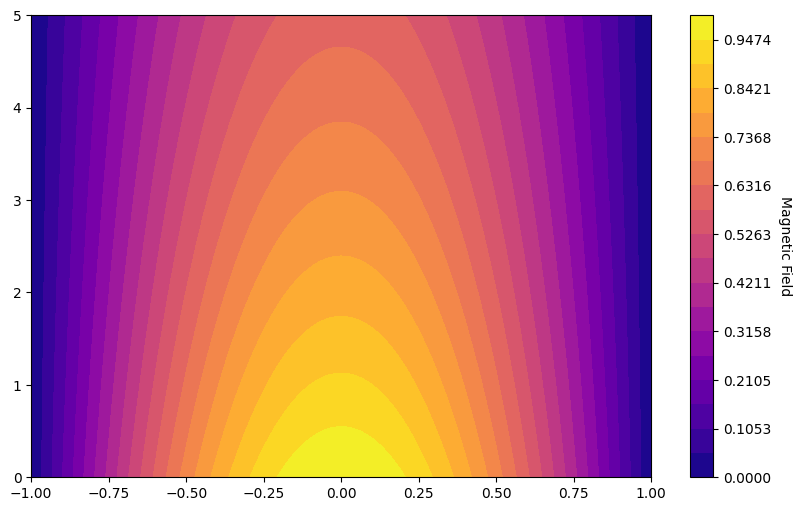

Gamma from z=0: -0.09869401667429804
Gamma from z=-h/3: -0.09869401667429782


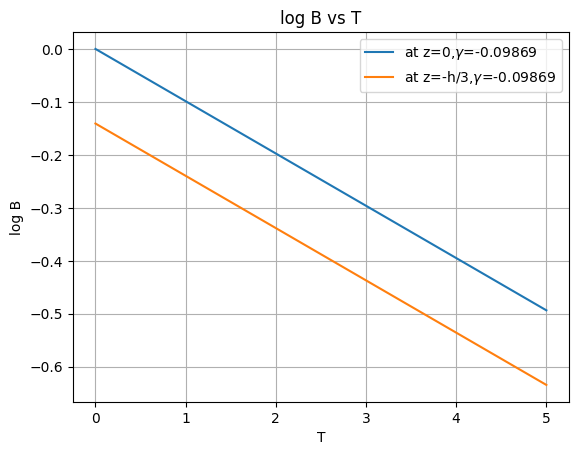

Decay($gamma$):-0.09869401667429804.
Pitch angle 0.7853981633974483 which is 0.25π .


In [14]:
B_z=plot_all(eta,Nx,Nt,L,T,calculate_B_i)

**Different Boundary Condition**

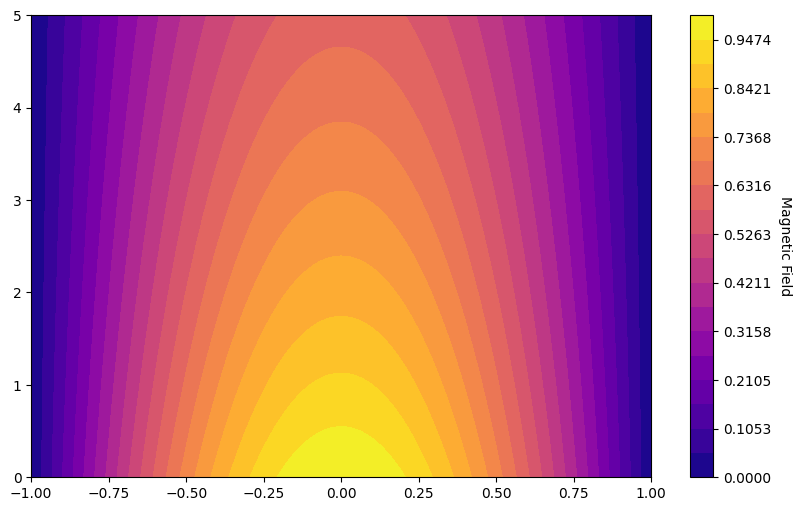

Gamma from z=0: -0.09869401667429804
Gamma from z=-h/3: -0.09869401667429782


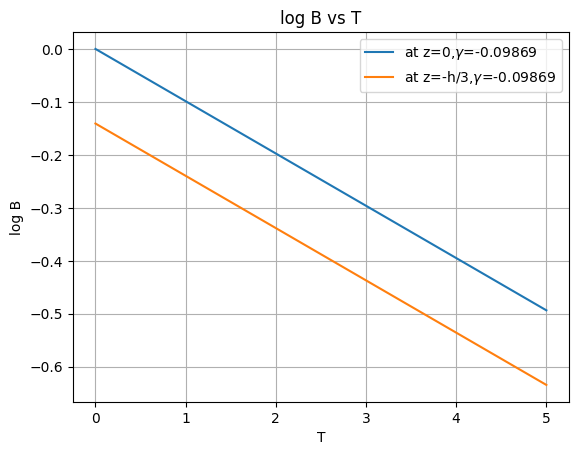

Decay($gamma$):-0.09869401667429804.
Pitch angle 0.7853981633974483 which is 0.25π .


In [16]:
def boundary_conditions_neuman(B,L=2):
    dx = L / (len(B) - 1)  
    B[0] = B[1] - dx * (B[2] - B[0]) / (2 * dx)  # Neumann boundary condition at left end
    B[-1] = B[-2] + dx * (B[-2] - B[-3]) / (2 * dx)  # Neumann boundary condition at right end

B_z_pm=plot_all(eta,Nx,Nt,L,T,calculate_B_i,crank_nicolson_magnetic_diffusion,initial_condition,boundary_conditions_neuman,1,1)

**Different Initial Condition**

The eigen modes are [8.393111444631964, 0.6640253781414025].


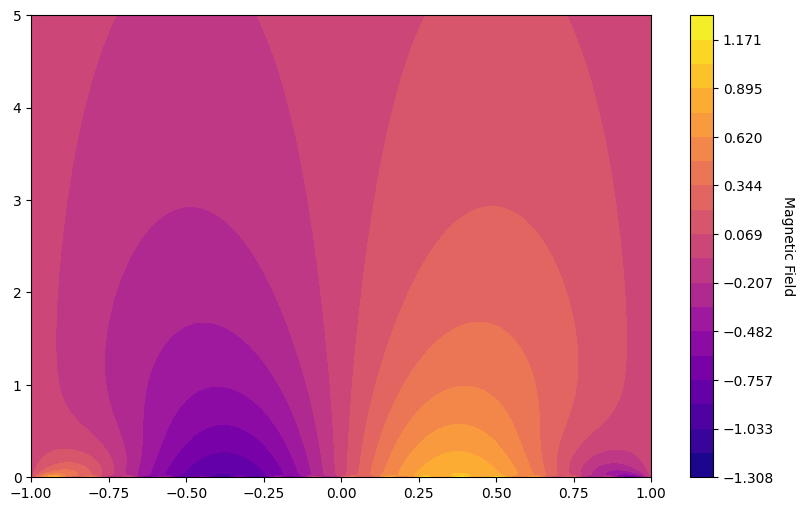

The eigen modes are [5.161005401943564, 4.048602650847277, 7.305799630314129, 5.285105889288559, 9.303371425181068, 0.3048355541498077, 2.0554796059350333].
The eigen modes are [8.037360143105198, 7.74360451509882, 1.568433889204792, 7.882983956800229, 5.254457621321132, 6.6874955956103115, 8.640581761576259].
Gamma from z=0: 0.9999999995991874
Gamma from z=-h/3: -0.5333384575733616


C:\Users\DeLL\AppData\Local\Temp\ipykernel_12564\4246596482.py:82: RuntimeWarning: divide by zero encountered in log
  log_B = np.log(B_middle)
C:\Users\DeLL\AppData\Local\Temp\ipykernel_12564\4246596482.py:82: RuntimeWarning: invalid value encountered in log
  log_B = np.log(B_middle)
C:\Users\DeLL\AppData\Local\Temp\ipykernel_12564\4246596482.py:83: RuntimeWarning: invalid value encountered in log
  log_B1 = np.log(B_thirds)


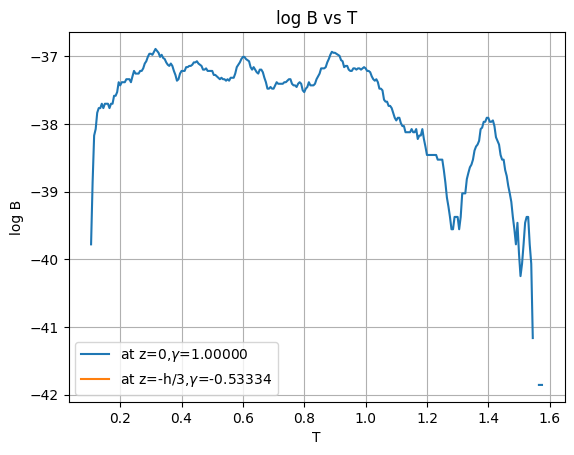

Decay($gamma$):0.9999999995991874.
Pitch angle -1.3674873189910002 which is -0.4352847328658023π .


In [22]:
B_z_eigen_modes_peak=plot_all(eta,Nx,Nt,L,T,calculate_B_i,crank_nicolson_magnetic_diffusion,initial_condition_multiple_modes,boundary_conditions,1,1)

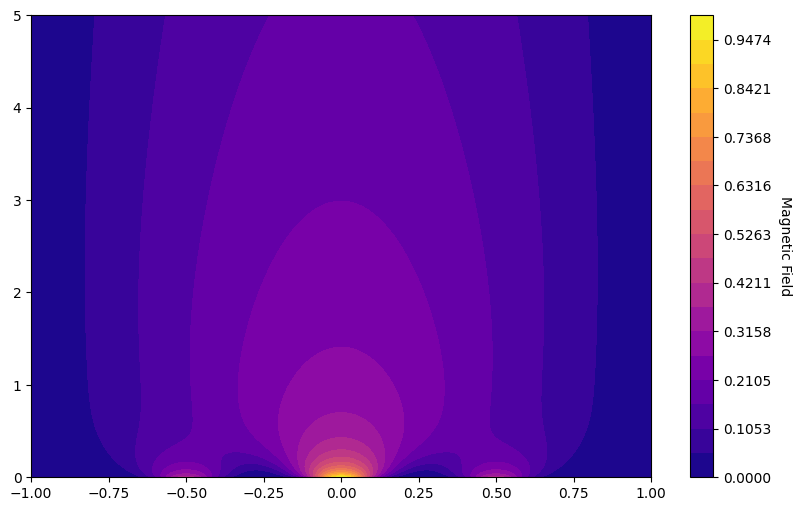

Gamma from z=0: -0.2570965254019118
Gamma from z=-h/3: -0.032564048782284846


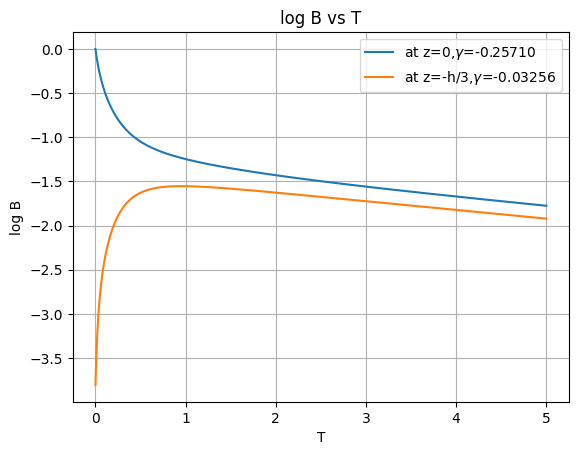

Decay($gamma$):-0.2570965254019118.
Pitch angle 0.7853981633974483 which is 0.25π .


In [17]:
def three_peak_initial(x,amp=1):
    peak1 = np.exp(-(x  / 0.1) ** 2)  # Peak at x = 0; x is normalised
    peak2 = np.exp(-((x + 0.5) / 0.1) ** 2)  # Peak at x = -0.5
    peak3 = np.exp(-((x - 0.5) / 0.1) ** 2)  # Peak at x = 0.5
    return amp*(1 * peak1 + 0.4 * peak2 + 0.4 * peak3)
B_z_3_peak=plot_all(eta,Nx,Nt,L,T,calculate_B_i,crank_nicolson_magnetic_diffusion,three_peak_initial,boundary_conditions,1,1)

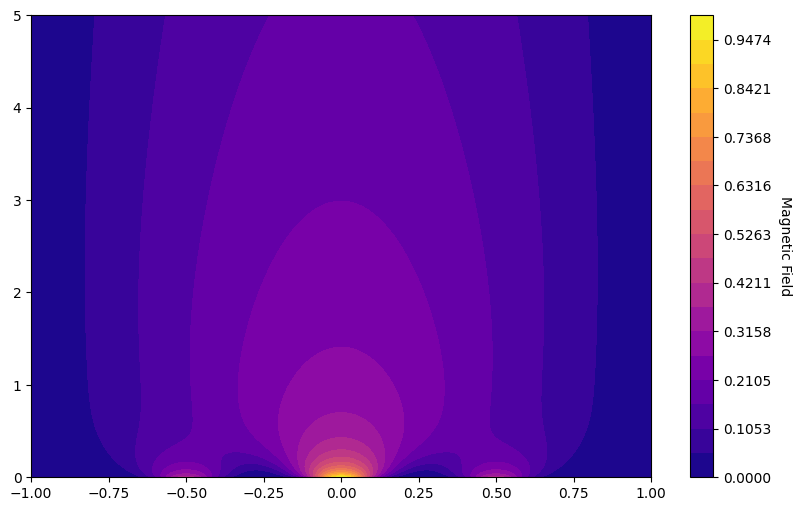

Gamma from z=0: -0.2570965254019118
Gamma from z=-h/3: -0.032564048782284846


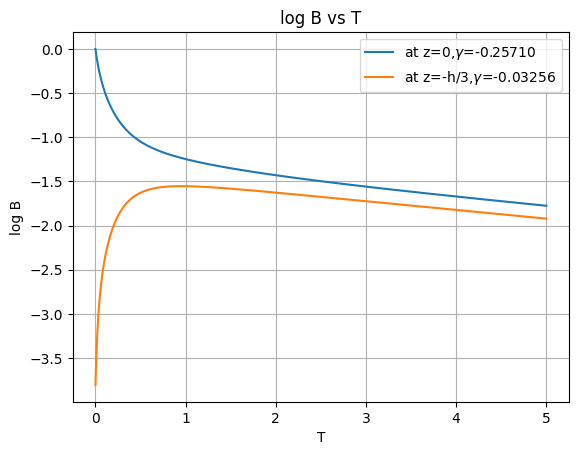

Decay($gamma$):-0.2570965254019118.
Pitch angle 0.7853981633974483 which is 0.25π .


In [18]:
def one_peak_initial(x,amp=1):
    peak1 = np.exp(-(x  / 0.1) ** 2)     
    return amp*(peak1)
B_z_1_peak=plot_all(eta,Nx,Nt,L,T,calculate_B_i,crank_nicolson_magnetic_diffusion,three_peak_initial,boundary_conditions,1,1)